In [26]:
import pandas as pd
from gurobipy import Model, GRB
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary, LpStatus, PULP_CBC_CMD
#from espn_api.football import League
#league = League(league_id=2113531198, year=2023, espn_s2='AEBGNcTtIkyeEgBLljv3A9BVG7xE1%2FQyCbXQvBF6NvSjCqdguy4VmCidrifavjN0KVMUahU27mtwAWARKz%2F6thmI2ZW1hP%2BlUeht9mLHWBnd8kz7fXCiw50KlbDNk4cCXaBn38v6TWpMaWXMV9C17Egs8g3WxjyOlCvEZKrkbq2yyf%2BltGPH%2BBQ5zp3MdB1MK6K12IazGncWBXEJvqrDtgq0J2Eb3ylEfMsSlGu2dFWXhGTl1uhPX%2F5Uh4Yehp0lJO7L8kl65Uq4QZcwFYZGZSJQ0qIg6Buj0osFQbjnm1yR2g%3D%3D', swid='{BF591EE3-B954-4E70-991E-E3B9544E7031}')

# read in fantasypros stat projections and adp
qbproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_QB.csv')
rbproj =  pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_RB.csv')
wrproj =  pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_WR.csv')
teproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_TE.csv')
kproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_K.csv')
dstproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_DST.csv')
adp = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_2023_Overall_ADP_Rankings.csv')

In [27]:
#### SCORING SYSTEM ####
passing_yards = 1/20
passing_tds = 4
passing_ints = -1
rushing_yards = 1/10
rushing_tds = 6
receiving_yards = 1/10
receiving_tds = 6
receptions = .5

In [28]:
# convert YDS, which is an object, to float by removing commas 
# do this only do the columns that need it
# in this case, a QB is projected to have >1k rushing yards, but not other positions have 
# a player projected to have >1k yards in their non-primary position
qbproj['YDS'] = qbproj['YDS'].str.replace(',', '').astype(float)
qbproj['YDS.1'] = qbproj['YDS.1'].str.replace(',', '').astype(float)
rbproj['YDS'] = rbproj['YDS'].str.replace(',', '').astype(float)
wrproj['YDS'] = wrproj['YDS'].str.replace(',', '').astype(float)
teproj['YDS'] = teproj['YDS'].str.replace(',', '').astype(float)

In [29]:
# use the stats projections to calculate the total projected fantasy points for each player using the scoring system
qbproj['Projection'] = qbproj['YDS'] * passing_yards + qbproj['TDS'] * passing_tds + qbproj['INTS'] * passing_ints + qbproj['YDS.1'] * rushing_yards + qbproj['TDS.1'] * rushing_tds
qbproj["Pos"] = "QB"
qbproj = qbproj[['Player', 'Projection', 'Pos']]

rbproj['Projection'] = rbproj['YDS'] * rushing_yards + rbproj['TDS'] * rushing_tds + rbproj['YDS.1'] * receiving_yards + rbproj['TDS.1'] * receiving_tds + rbproj['REC'] * receptions
rbproj["Pos"] = "RB"
rbproj = rbproj[['Player', 'Projection', 'Pos']]

wrproj['Projection'] = wrproj['YDS'] * receiving_yards + wrproj['TDS'] * receiving_tds + wrproj['YDS.1'] * rushing_yards + wrproj['TDS.1'] * rushing_tds + wrproj['REC'] * receptions
wrproj["Pos"] = "WR"
wrproj = wrproj[['Player', 'Projection', 'Pos']]

teproj['Projection'] = teproj['YDS'] * receiving_yards + teproj['TDS'] * receiving_tds + teproj['REC'] * receptions
teproj["Pos"] = "TE"
teproj = teproj[['Player', 'Projection', 'Pos']]

kproj['Projection'] = kproj['FPTS']
kproj["Pos"] = "K"
kproj = kproj[['Player', 'Projection', 'Pos']]

dstproj['Projection'] = dstproj['FPTS']
dstproj["Pos"] = "DST"
dstproj = dstproj[['Player', 'Projection', 'Pos']]

In [30]:
# combine all projections into one dataframe
proj = pd.concat([qbproj, rbproj, wrproj, teproj, kproj,dstproj])
# join projections with adp
df = pd.merge(proj, adp, on='Player', how='outer')
# delete any rows with NaN in the Rank column or projection column
df = df.dropna(subset=['Rank', 'Projection'])
# create a column that ranks each player by position based on their projection
df['pos_rank'] = df.groupby('POS')['Projection'].rank(ascending=False)
df = df[['Player', 'Projection', 'Pos', 'Rank', 'pos_rank']]

### Clustering for tiers

#### QB ####

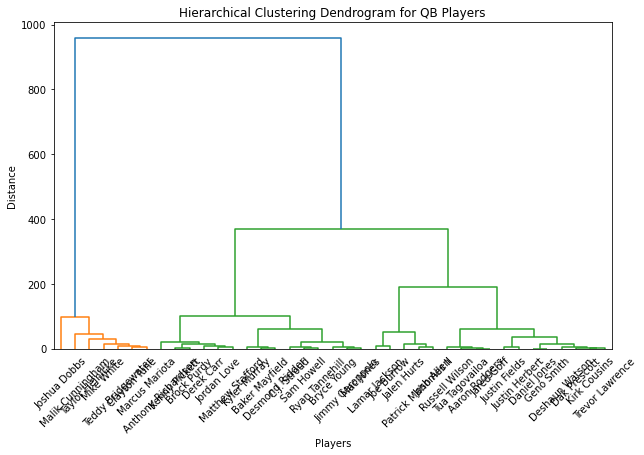

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import matplotlib.pyplot as plt

# QB clustering
pos_df = df[df['Pos'] == 'QB']
# take the top 30 QBs
pos_df = pos_df[pos_df['pos_rank'] < 30]
# make the pos_rank the index and sort by it - this makes players appear in tiers in order
pos_df.index = pos_df['pos_rank']
pos_df = pos_df.sort_index()
# create a dendrogram
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for QB Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [32]:
# use the dendrogram to determine the number of clusters
num_clusters = 7
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()
# sort the clusters by average projection
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers - i.e. 1 being the top tier, etc.
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]

# print the clusters out for inspection - can rerun this cell to see different clusters
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()


Cluster 1:
                      Player  Projection
pos_rank                                
1.0       Patrick Mahomes II     436.510
1.0               Josh Allen     432.535
1.0              Jalen Hurts     422.320
1.0            Lamar Jackson     392.310
1.0               Joe Burrow     401.615

Cluster 2:
                   Player  Projection
pos_rank                             
1.0         Justin Fields     366.705
1.0        Justin Herbert     371.710
1.0        Deshaun Watson     354.000
1.0          Dak Prescott     349.670
1.0          Kirk Cousins     350.910
1.0       Trevor Lawrence     351.855
1.0          Daniel Jones     343.290
1.0            Geno Smith     343.405

Cluster 3:
                  Player  Projection
pos_rank                            
1.0        Aaron Rodgers     329.030
1.0       Russell Wilson     324.495
1.0       Tua Tagovailoa     327.100
1.0           Jared Goff     329.055

Cluster 4:
                      Player  Projection
pos_rank               

#### RB ####

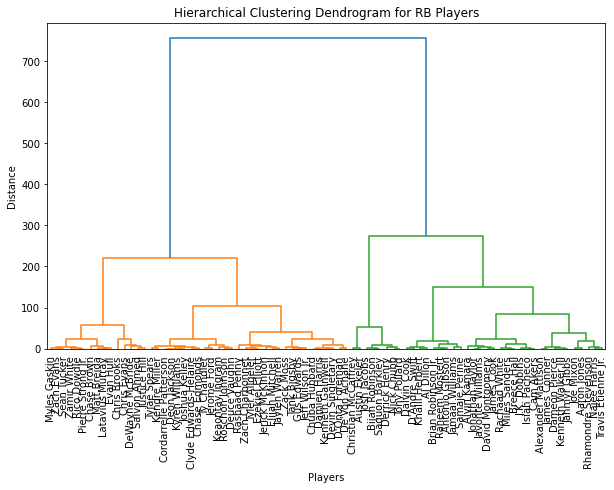

In [33]:
pos_df = df[df['Pos'] == 'RB']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] < 60]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for RB Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [34]:
num_clusters = 8
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]

for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()



Cluster 1:
                       Player  Projection
pos_rank                                 
1.0       Christian McCaffrey      273.62
1.0             Austin Ekeler      271.16
1.0                Nick Chubb      242.89
1.0             Derrick Henry      245.81
1.0              Tony Pollard      242.78
1.0               Josh Jacobs      237.62
1.0            Bijan Robinson      239.83
1.0            Saquon Barkley      239.60

Cluster 2:
                       Player  Projection
pos_rank                                 
1.0                 Joe Mixon      215.43
1.0               Aaron Jones      213.37
1.0              Najee Harris      199.76
1.0        Travis Etienne Jr.      200.45
1.0       Rhamondre Stevenson      204.59
1.0        Kenneth Walker III      188.00
1.0        Alexander Mattison      191.44
1.0              James Conner      191.42
1.0             Dameon Pierce      188.51
1.0              Jahmyr Gibbs      188.22

Cluster 3:
                    Player  Projection
po

#### TE ####

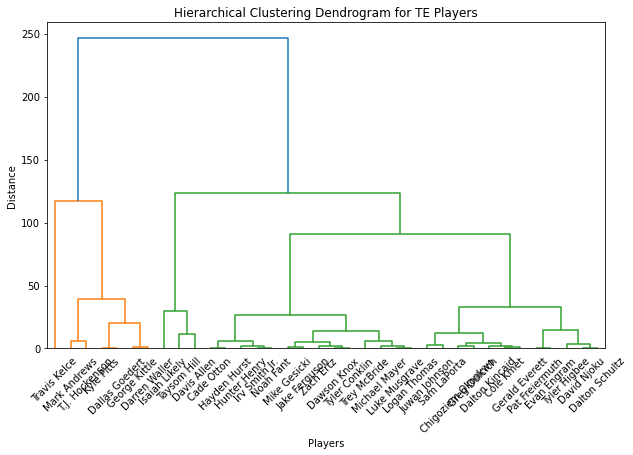

In [35]:
pos_df = df[df['Pos'] == 'TE']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] <= 24]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for TE Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [36]:
num_clusters = 7
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()



Cluster 1:
                Player  Projection
pos_rank                          
1.0       Travis Kelce      235.61

Cluster 2:
                  Player  Projection
pos_rank                            
1.0         Mark Andrews      165.51
1.0       T.J. Hockenson      159.28

Cluster 3:
                  Player  Projection
pos_rank                            
1.0        George Kittle      144.75
1.0        Darren Waller      146.31
1.0           Kyle Pitts      131.00
1.0       Dallas Goedert      131.11

Cluster 4:
                  Player  Projection
pos_rank                            
1.0       Pat Freiermuth      118.75
1.0          Evan Engram      118.28
1.0          David Njoku      109.72
1.0       Dalton Schultz      110.32
1.0         Tyler Higbee      107.03

Cluster 5:
                     Player  Projection
pos_rank                               
1.0       Chigoziem Okonkwo      103.72
1.0            Greg Dulcich      102.07
1.0               Cole Kmet      100.82
1.0    

#### WR ####

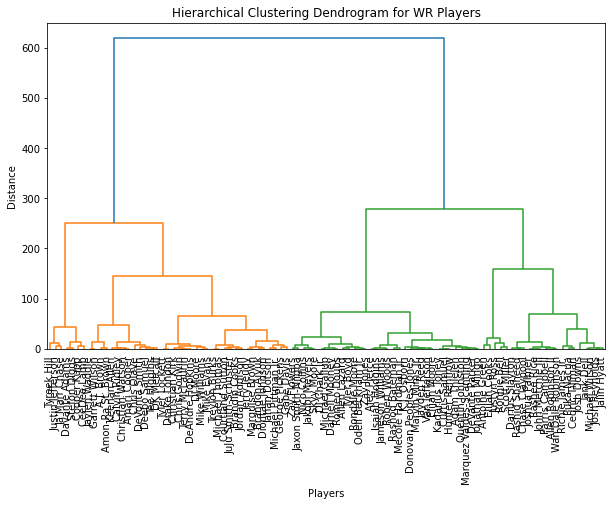

In [37]:
pos_df = df[df['Pos'] == 'WR']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] < 72]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for WR Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [38]:
num_clusters = 9
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()



Cluster 1:
                    Player  Projection
pos_rank                              
1.0       Justin Jefferson      262.63
1.0          Ja'Marr Chase      257.45
1.0            Tyreek Hill      249.92
1.0            Cooper Kupp      239.79
1.0            CeeDee Lamb      235.01
1.0          Davante Adams      227.71
1.0           Stefon Diggs      228.59

Cluster 2:
                     Player  Projection
pos_rank                               
1.0              A.J. Brown      212.21
1.0           Jaylen Waddle      202.20
1.0       Amon-Ra St. Brown      210.51
1.0          Garrett Wilson      201.74
1.0            Deebo Samuel      187.65
1.0             Chris Olave      194.52
1.0             Tee Higgins      189.26
1.0        Christian Watson      182.58
1.0            Amari Cooper      182.95
1.0              DK Metcalf      188.55
1.0           DeVonta Smith      185.94
1.0           Calvin Ridley      183.62
1.0            Keenan Allen      181.81

Cluster 3:
              

#### K ####

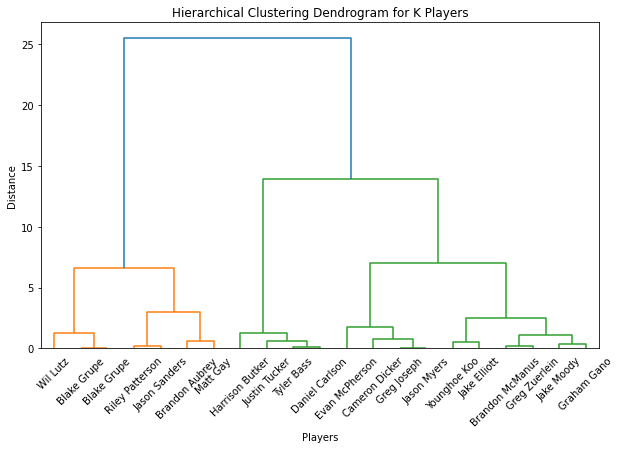

In [39]:
pos_df = df[df['Pos'] == 'K']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] <= 12]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for K Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [40]:
num_clusters = 3
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()


Cluster 1:
                   Player  Projection
pos_rank                             
1.0       Harrison Butker       125.6
1.0            Tyler Bass       124.8
1.0        Daniel Carlson       124.7
1.0         Justin Tucker       124.2

Cluster 2:
                   Player  Projection
pos_rank                             
1.0        Evan McPherson       122.0
1.0           Greg Joseph       120.8
1.0           Jason Myers       120.8
1.0        Cameron Dicker       120.1
1.0          Younghoe Koo       119.0
1.0          Jake Elliott       118.5
1.0       Brandon McManus       117.7
1.0         Greg Zuerlein       117.5
1.0            Jake Moody       117.0
1.0           Graham Gano       116.6

Cluster 3:
                   Player  Projection
pos_rank                             
1.0       Riley Patterson       115.0
1.0         Jason Sanders       114.8
1.0        Brandon Aubrey       113.1
1.0              Matt Gay       112.5
1.0              Wil Lutz       111.0
1.0           B

#### DST ####

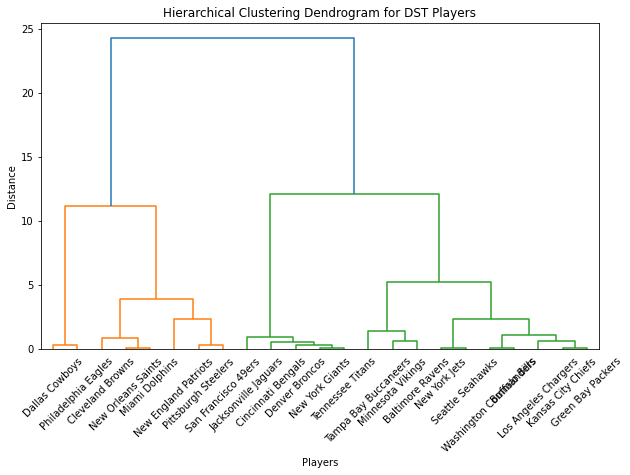

In [41]:
pos_df = df[df['Pos'] == 'DST']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] <= 12]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for DST Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [42]:
num_clusters = 3
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()


Cluster 1:
                        Player  Projection
pos_rank                                  
1.0             Dallas Cowboys       114.5
1.0        Philadelphia Eagles       114.2
1.0       New England Patriots       110.4
1.0        Pittsburgh Steelers       108.5
1.0        San Francisco 49ers       108.2
1.0           Cleveland Browns       107.3
1.0         New Orleans Saints       106.6
1.0             Miami Dolphins       106.5

Cluster 2:
                         Player  Projection
pos_rank                                   
1.0       Washington Commanders       105.2
1.0               Buffalo Bills       105.1
1.0          Kansas City Chiefs       104.7
1.0           Green Bay Packers       104.6
1.0        Los Angeles Chargers       104.1
1.0               New York Jets       103.4
1.0            Seattle Seahawks       103.3
1.0           Minnesota Vikings       102.5
1.0            Baltimore Ravens       101.9
1.0        Tampa Bay Buccaneers       101.0

Cluster 3:
       

In [43]:
# drop players with no cluster
df = df.dropna(subset=['Cluster'])
df['Cluster'] = df['Cluster'].astype(int)
# write to csv
df.to_csv('2023_Draft.csv', index=False)